In [ ]:
pip install pytorch_fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import models,datasets,transforms
from PIL import Image
from tqdm import tqdm

import os
import matplotlib.pyplot as plt
import numpy as np

from pytorch_fid.fid_score import calculate_activation_statistics,calculate_frechet_distance
from pytorch_fid . inception import InceptionV3
import shutil


In [ ]:
class IndexedDataset(Dataset):
    def __init__(self, dir_path):
        self.dir_path = dir_path        
        #The transforms that will be applied to each image
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
          ])
        #Saving all the image locations
        self.image_filenames = []
        for (dirpath, dirnames, filenames) in os.walk(dir_path): 
            self.image_filenames += [os.path.join(dirpath, file) for file in filenames]
        
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx] #Getting the name of the image
        image = Image.open(img_name).convert('RGB') #opening the image
        image = self.transform(image) #Applying the transforms to the image
        return image


In [ ]:
#Inspired by https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.convt1 = nn.ConvTranspose2d( 100, 64 * 8, 4, 1, 0, bias=False)
        self.convt2 = nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False)
        self.convt3 = nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False)
        self.convt4 = nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False)
        self.convt5 = nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64 * 8)
        self.bn2 = nn.BatchNorm2d(64 * 4)
        self.bn3 = nn.BatchNorm2d(64*2)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()
        
    def forward(self, input):
        x = self.relu(self.bn1(self.convt1(input)))
        x = self.relu(self.bn2(self.convt2(x)))
        x = self.relu(self.bn3(self.convt3(x)))
        x = self.relu(self.bn4(self.convt4(x)))
        x = self.tanh(self.convt5(x))
        return x

In [ ]:
#Inspired by https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False)
        self.conv5 = nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False)
        self.bn2 = nn.BatchNorm2d(64 * 2)
        self.bn3 = nn.BatchNorm2d(64 * 4) 
        self.bn4 = nn.BatchNorm2d(64 * 8)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        x = self.relu(self.conv1(input))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.sigmoid(self.conv5(x))
        return x

In [ ]:
#Initializing the weights
#From https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
#Function to train the model
def training(epochs,optimizerD,optimizerG,criterion,netG,netD,train_data_loader,device,batch_size,model,m1,s1):
  #Storing the losses of the Generator and Discriminator
  train_lossesG = []
  train_lossesD = []
  fid_score = []

  #Assigning labels to the real and fake images
  real_label = 1
  fake_label = 0

  for epoch in range(epochs):
    running_lossG = 0.0
    running_lossD = 0.0
    for i,data in enumerate(train_data_loader):
      #Part 1: Training the Discriminator
      #Part A: On the real images
      optimizerD.zero_grad()
      inputs_real = data.to(device) #Getting the real image
      num_images = data.shape[0] #Getting the batch size
      labels_real = torch.full((num_images,),real_label,dtype=torch.float).to(device)  #Generating the labels for real images   
      
      outputs_real = netD(inputs_real).view(-1) #Getting the predicted labels for the real images
      loss_real = criterion(outputs_real, labels_real) #Calculating the loss on real images
      loss_real.backward()

      #Part B: On the fake images
      noise = torch.randn((num_images,100,1,1)).to(device) #Generating the loss
      inputs_fake = netG(noise) #Generating the fake images from this noise
      labels_fake = torch.full((num_images,),fake_label,dtype=torch.float).to(device) #Generating the labels for fake images
      outputs_fake = netD(inputs_fake.detach()).view(-1) #Getting the predicted labels for the fake images
      loss_fake = criterion(outputs_fake, labels_fake) #Calculating the loss on fake images
      loss_fake.backward()

      optimizerD.step()
      running_lossD += loss_real.cpu().item() + loss_fake.cpu().item()

      #Part 2: Training the Generator
      optimizerG.zero_grad()
      outputs_fake_G = netD(inputs_fake).view(-1) #Genrating the predicted labels for the fake images
      loss_G = criterion(outputs_fake_G, labels_real) #In the optimum case the fake images should be predicted as real by the discriminator
      loss_G.backward()
      optimizerG.step()
      running_lossG += loss_G.cpu().item()

    print("[epoch: %d, batch: %5d] Discriminator loss: %.3f Generator loss: %.3f" % (epoch + 1, i + 1, (running_lossD)/(i+1),(running_lossG)/(i+1)))
    train_lossesG.append(running_lossG/len(train_data_loader.dataset))
    train_lossesD.append(running_lossD/len(train_data_loader.dataset))
    fid = calc_fid(netG,device,m1,s1,model)
    fid_score.append(fid)
  return netG, train_lossesG, train_lossesD, fid_score

In [ ]:
#Function to Plot a real image
def plot_image_real(dataset,index):
  img = dataset[index] #Getting the image
  i = np.transpose(np.asarray(img*127.5 + 127.5).astype(int),(1,2,0)) #converting the image from tensor to numpy
  ci = np.ascontiguousarray(i, dtype=np.uint8) #Making the array contiguous  
  return ci.astype(int)  #returns the image 

In [ ]:
#Function to Plot a fake image
def plot_image_fake(netG,device):
  noise = torch.randn((1,100,1,1)).to(device)
  img = netG(noise).cpu().detach() #Getting the image
  img = img.squeeze()
  i = np.transpose(np.asarray(img*127.5 + 127.5).astype(int),(1,2,0)) #converting the image from tensor to numpy
  ci = np.ascontiguousarray(i, dtype=np.uint8) #Making the array contiguous  
  return ci.astype(int)  #returns the image 

In [ ]:
#Function to save a fake image
def save_image_fake(img,i):
  im = Image.fromarray(img.astype(np.uint8))
  im.save("fake/"+str(i)+".jpeg")

In [ ]:
#Function to calculate FID
def calc_fid(netG,device,m1,s1,model):
  #Generating 1000 fake images
  for i in range(1000):
    img = plot_image_fake(netG,device)
    save_image_fake(img,i)
  fake_paths = ["fake/" +str(i)+".jpeg" for i in range(0, 1000)] #Generating the path for the directory containing fake images
  #Obtaining the feature encoding for the real test images
  m2 , s2 = calculate_activation_statistics(fake_paths, model,device = device)
  fid_value = calculate_frechet_distance(m1,s1,m2,s2) #Calculating FID value
  print("FID: "+str(fid_value)) 
  return fid_value


In [ ]:
#Function to Plot 4x4 images
def plot_collage(dataset,device,type_of="real",model=None):
  images = []
  if type_of=="real": #If you want real image generated
    indices = np.random.randint(0,len(dataset),16) #Getting 16 random indices
    for i in indices:
      images.append(plot_image_real(dataset,i)) #Saving the 16 images

  elif type_of=="fake": #If you want fake image generated
    for i in range(16):
      images.append(plot_image_fake(model,device)) #Saving the 16 images

  fig = plt.figure(figsize = (10,10))

  ax11 = fig.add_subplot(4,4,1)
  ax12 = fig.add_subplot(4,4,2)
  ax13 = fig.add_subplot(4,4,3)
  ax14 = fig.add_subplot(4,4,4)
  ax21 = fig.add_subplot(4,4,5)
  ax22 = fig.add_subplot(4,4,6)
  ax23 = fig.add_subplot(4,4,7)
  ax24 = fig.add_subplot(4,4,8)
  ax31 = fig.add_subplot(4,4,9)
  ax32 = fig.add_subplot(4,4,10)
  ax33 = fig.add_subplot(4,4,11)
  ax34 = fig.add_subplot(4,4,12)
  ax41 = fig.add_subplot(4,4,13)
  ax42 = fig.add_subplot(4,4,14)
  ax43 = fig.add_subplot(4,4,15)
  ax44 = fig.add_subplot(4,4,16)

  ax11.axis('off')
  ax12.axis('off')
  ax13.axis('off')
  ax14.axis('off')
  ax21.axis('off')
  ax22.axis('off')
  ax23.axis('off')
  ax24.axis('off')
  ax31.axis('off')
  ax32.axis('off')
  ax33.axis('off')
  ax34.axis('off')
  ax41.axis('off')
  ax42.axis('off')
  ax43.axis('off')
  ax44.axis('off')

  ax11.imshow(images[0])
  ax12.imshow(images[1])
  ax13.imshow(images[2])
  ax14.imshow(images[3])
  ax21.imshow(images[4])
  ax22.imshow(images[5])
  ax23.imshow(images[6])
  ax24.imshow(images[7])
  ax31.imshow(images[8])
  ax32.imshow(images[9])
  ax33.imshow(images[10])
  ax34.imshow(images[11])
  ax41.imshow(images[12])
  ax42.imshow(images[13])
  ax43.imshow(images[14])
  ax44.imshow(images[15])     

In [ ]:
train_dataset = IndexedDataset("/content/drive/MyDrive/pizzas/train")
test_dataset = IndexedDataset("/content/drive/MyDrive/pizzas/eval")

train_dataloader = DataLoader(train_dataset,batch_size=16,num_workers=64)
test_dataloader = DataLoader(test_dataset,batch_size=16,num_workers=64)

print(len(train_dataloader))
print(len(test_dataloader))

514
63


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
netG = Generator().to(device)
netG.apply(weights_init)
netD = Discriminator().to(device)
netD.apply(weights_init)

optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0001, betas = (0.5, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0001, betas = (0.5, 0.999))
criterion = nn.BCELoss()
epochs = 40



In [ ]:
#The number of parameters in the Generator
sum(p.numel() for p in netG.parameters() if p.requires_grad)

3576704

In [ ]:
#The number of parameters in the Discriminator
sum(p.numel() for p in netD.parameters() if p.requires_grad)

2765568

In [ ]:
#Creating an instance of the InceptionV3 model
dims = 2048
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx]).to(device)

In [ ]:
#Obtaining the feature encoding for the real test images
real_paths = test_dataset.image_filenames
m1 , s1 = calculate_activation_statistics(real_paths,model,device = device)

100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


In [ ]:
trained_generator,train_lossesG, train_lossesD,fid_score = training(epochs,optimizerD,optimizerG,criterion,netG,netD,train_dataloader,device,16,model,m1,s1)

[epoch: 1, batch:   514] Discriminator loss: 0.424 Generator loss: 6.433


100%|██████████| 20/20 [00:03<00:00,  5.13it/s]


FID: 326.65443838158586
[epoch: 2, batch:   514] Discriminator loss: 0.424 Generator loss: 5.997


100%|██████████| 20/20 [00:03<00:00,  5.10it/s]


FID: 280.54213066301094
[epoch: 3, batch:   514] Discriminator loss: 0.465 Generator loss: 5.714


100%|██████████| 20/20 [00:03<00:00,  5.09it/s]


FID: 294.5241699903557
[epoch: 4, batch:   514] Discriminator loss: 0.495 Generator loss: 4.957


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


FID: 249.88407004232243
[epoch: 5, batch:   514] Discriminator loss: 0.578 Generator loss: 4.487


100%|██████████| 20/20 [00:03<00:00,  5.01it/s]


FID: 256.457269878806
[epoch: 6, batch:   514] Discriminator loss: 0.536 Generator loss: 4.414


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


FID: 248.87193660791527
[epoch: 7, batch:   514] Discriminator loss: 0.422 Generator loss: 4.488


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


FID: 228.48034663993957
[epoch: 8, batch:   514] Discriminator loss: 0.357 Generator loss: 4.537


100%|██████████| 20/20 [00:03<00:00,  5.03it/s]


FID: 215.6269016631535
[epoch: 9, batch:   514] Discriminator loss: 0.398 Generator loss: 4.672


100%|██████████| 20/20 [00:04<00:00,  4.99it/s]


FID: 231.20517305247384
[epoch: 10, batch:   514] Discriminator loss: 0.361 Generator loss: 4.546


100%|██████████| 20/20 [00:03<00:00,  5.04it/s]


FID: 185.93738960979582
[epoch: 11, batch:   514] Discriminator loss: 0.362 Generator loss: 4.743


100%|██████████| 20/20 [00:04<00:00,  4.84it/s]


FID: 212.86834020474492
[epoch: 12, batch:   514] Discriminator loss: 0.328 Generator loss: 5.147


100%|██████████| 20/20 [00:04<00:00,  4.89it/s]


FID: 175.61513039953206
[epoch: 13, batch:   514] Discriminator loss: 0.333 Generator loss: 5.156


100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


FID: 176.4242772290113
[epoch: 14, batch:   514] Discriminator loss: 0.338 Generator loss: 5.021


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


FID: 175.0178456894143
[epoch: 15, batch:   514] Discriminator loss: 0.305 Generator loss: 5.046


100%|██████████| 20/20 [00:03<00:00,  5.03it/s]


FID: 164.1422412037743
[epoch: 16, batch:   514] Discriminator loss: 0.262 Generator loss: 5.196


100%|██████████| 20/20 [00:03<00:00,  5.06it/s]


FID: 169.60500789817704
[epoch: 17, batch:   514] Discriminator loss: 0.313 Generator loss: 5.368


100%|██████████| 20/20 [00:03<00:00,  5.05it/s]


FID: 157.19061501924202
[epoch: 18, batch:   514] Discriminator loss: 0.286 Generator loss: 5.509


100%|██████████| 20/20 [00:03<00:00,  5.04it/s]


FID: 181.5290294549249
[epoch: 19, batch:   514] Discriminator loss: 0.265 Generator loss: 5.452


100%|██████████| 20/20 [00:03<00:00,  5.05it/s]


FID: 163.95781924682936
[epoch: 20, batch:   514] Discriminator loss: 0.245 Generator loss: 5.418


100%|██████████| 20/20 [00:03<00:00,  5.07it/s]


FID: 150.32994359578674
[epoch: 21, batch:   514] Discriminator loss: 0.258 Generator loss: 5.839


100%|██████████| 20/20 [00:04<00:00,  4.84it/s]


FID: 170.2497956552666
[epoch: 22, batch:   514] Discriminator loss: 0.233 Generator loss: 5.745


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


FID: 141.5509412368808
[epoch: 23, batch:   514] Discriminator loss: 0.167 Generator loss: 5.669


100%|██████████| 20/20 [00:03<00:00,  5.04it/s]


FID: 179.60902907296395
[epoch: 24, batch:   514] Discriminator loss: 0.298 Generator loss: 6.132


100%|██████████| 20/20 [00:03<00:00,  5.01it/s]


FID: 136.86577750640282
[epoch: 25, batch:   514] Discriminator loss: 0.214 Generator loss: 5.978


100%|██████████| 20/20 [00:04<00:00,  4.98it/s]


FID: 136.97529101350125
[epoch: 26, batch:   514] Discriminator loss: 0.193 Generator loss: 5.978


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


FID: 163.44106519738614
[epoch: 27, batch:   514] Discriminator loss: 0.135 Generator loss: 6.929


100%|██████████| 20/20 [00:03<00:00,  5.08it/s]


FID: 178.3738545989441
[epoch: 28, batch:   514] Discriminator loss: 0.204 Generator loss: 6.203


100%|██████████| 20/20 [00:03<00:00,  5.10it/s]


FID: 131.6325725460171
[epoch: 29, batch:   514] Discriminator loss: 0.214 Generator loss: 6.073


100%|██████████| 20/20 [00:03<00:00,  5.00it/s]


FID: 146.86127807795725
[epoch: 30, batch:   514] Discriminator loss: 0.189 Generator loss: 6.265


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


FID: 125.63308913224046
[epoch: 31, batch:   514] Discriminator loss: 0.186 Generator loss: 6.206


100%|██████████| 20/20 [00:03<00:00,  5.01it/s]


FID: 136.91085661238992
[epoch: 32, batch:   514] Discriminator loss: 0.195 Generator loss: 6.346


100%|██████████| 20/20 [00:03<00:00,  5.08it/s]


FID: 128.77608369407548
[epoch: 33, batch:   514] Discriminator loss: 0.239 Generator loss: 6.165


100%|██████████| 20/20 [00:03<00:00,  5.09it/s]


FID: 131.2492242695896
[epoch: 34, batch:   514] Discriminator loss: 0.201 Generator loss: 5.925


100%|██████████| 20/20 [00:03<00:00,  5.03it/s]


FID: 138.8652324338804
[epoch: 35, batch:   514] Discriminator loss: 0.199 Generator loss: 6.231


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


FID: 146.67440994463624
[epoch: 36, batch:   514] Discriminator loss: 0.204 Generator loss: 6.288


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


FID: 136.2584942206002
[epoch: 37, batch:   514] Discriminator loss: 0.107 Generator loss: 5.978


100%|██████████| 20/20 [00:03<00:00,  5.07it/s]


FID: 117.39881057336171
[epoch: 38, batch:   514] Discriminator loss: 0.316 Generator loss: 6.213


100%|██████████| 20/20 [00:03<00:00,  5.02it/s]


FID: 120.46372659289008
[epoch: 39, batch:   514] Discriminator loss: 0.247 Generator loss: 5.863


100%|██████████| 20/20 [00:03<00:00,  5.06it/s]


FID: 128.1825003736143
[epoch: 40, batch:   514] Discriminator loss: 0.172 Generator loss: 5.838


100%|██████████| 20/20 [00:03<00:00,  5.05it/s]


FID: 124.69029362343429


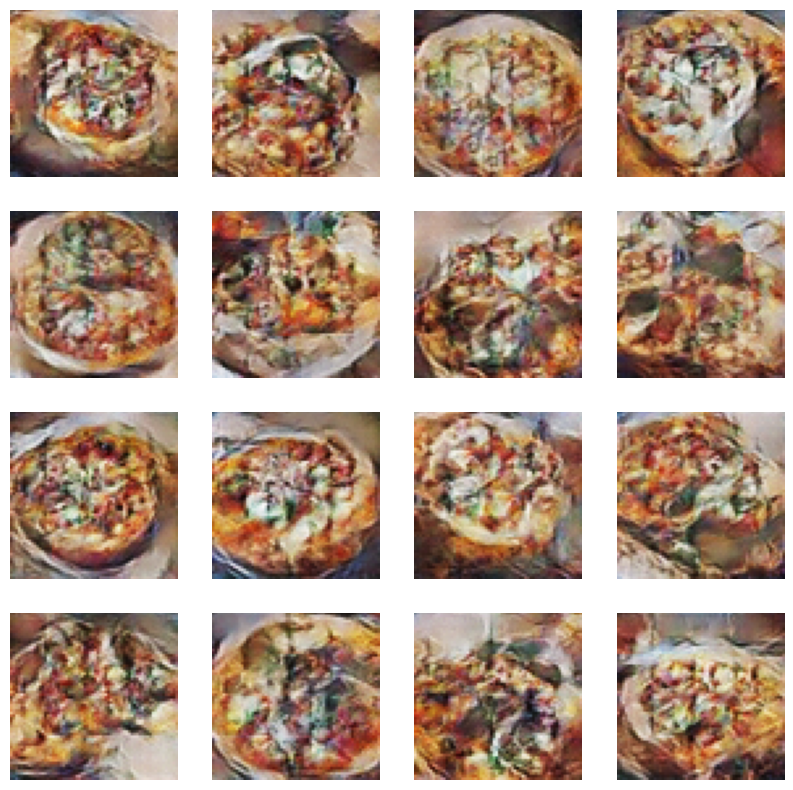

In [ ]:
#Fake images
plot_collage(train_dataset,device,type_of="fake",model=trained_generator)

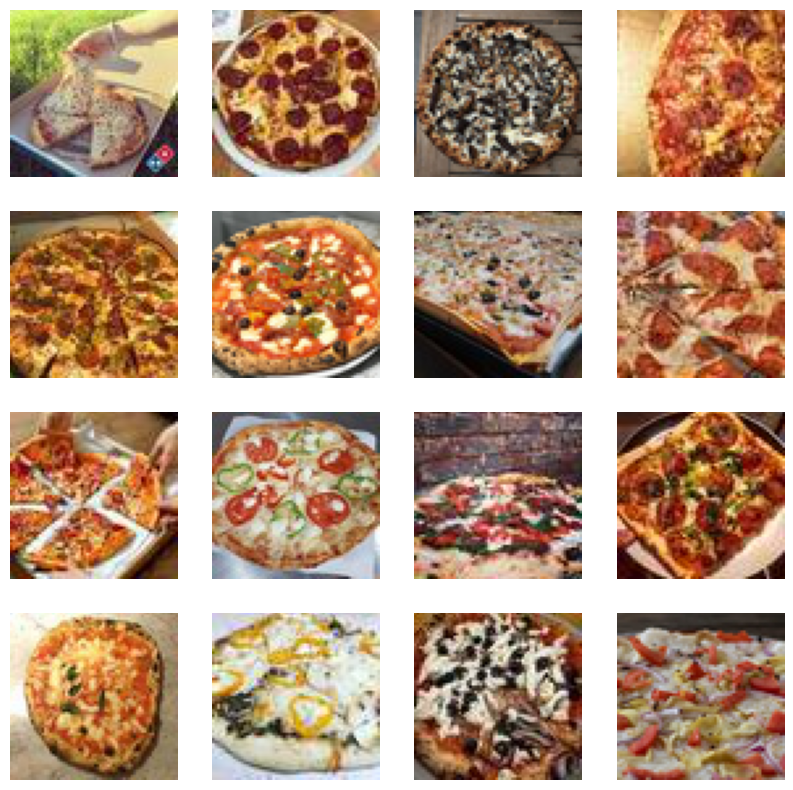

In [ ]:
#Real Images
plot_collage(train_dataset,device,type_of="real",model=None)

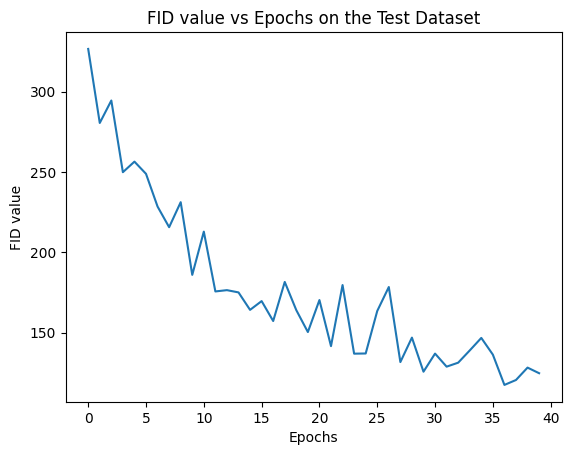

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("FID value")
plt.title("FID value vs Epochs on the Test Dataset")
plt.plot(fid_score)

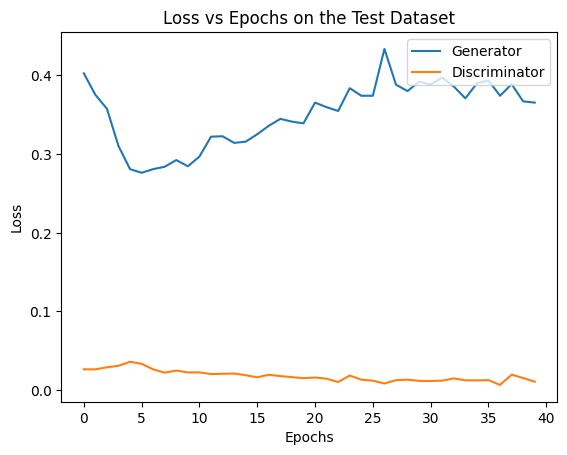

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs on the Test Dataset") #This should be training dataset
plt.plot(train_lossesG,label="Generator")
plt.plot(train_lossesD, label="Discriminator")
plt.legend(loc = "upper right")